In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from matplotlib.lines import Line2D

In [2]:
df = pd.read_csv("wimbledon.csv")

Define a function for plotting the Markov chain of transitions at some level.

In [3]:
def plot_markov(*, target, target_lo, target_hi, end_decision_func, figsize, node_size, font_base):
    # Count the transitions
    transition_counts = {}
    for i in range(1, len(df)):
        cur_row, prev_row = df.iloc[i], df.iloc[i - 1]
        cur_state = (cur_row[f"p1_{target}s"], cur_row[f"p2_{target}s"])
        prev_state = (prev_row[f"p1_{target}s"], prev_row[f"p2_{target}s"])
        if prev_state != cur_state:
            if cur_state == (0, 0) and end_decision_func(prev_state):
                if prev_row[f"{target_lo}_victor"] == 1:
                    cur_state = (prev_state[0] + 1, prev_state[1])
                elif prev_row[f"{target_lo}_victor"] == 2:
                    cur_state = (prev_state[0], prev_state[1] + 1)
            if prev_state not in transition_counts:
                transition_counts[prev_state] = {}
            if cur_state not in transition_counts[prev_state]:
                transition_counts[prev_state][cur_state] = 0
            transition_counts[prev_state][cur_state] += 1

    # Validate and drop violations
    violations = []
    for prev_state, next_states in transition_counts.items():
        for next_state, count in next_states.items():
            if next_state == (0, 0) or (
                next_state[0] != prev_state[0] + 1
                and next_state[1] != prev_state[1] + 1
            ):
                violations.append((prev_state, next_state, count))
    for prev_state, next_state, count in violations:
        del transition_counts[prev_state][next_state]
        print(
            f"\033[33m{count} violation(s): {prev_state} -> {next_state}; dropped\033[0m"
        )

    # Normalize the transition counts into probabilities
    transition_probs = {}
    for prev_state, next_states in transition_counts.items():
        total_transitions = sum(next_states.values())
        transition_probs[prev_state] = {
            next_state: count / total_transitions
            for next_state, count in next_states.items()
        }

    # Create the transition graph
    G = nx.DiGraph()
    all_nodes = {}
    for prev_state, next_states in transition_probs.items():
        for next_state, prob in next_states.items():
            prev_repr = f"{prev_state[0]}-{prev_state[1]}"
            prev_label = sum(prev_state)
            if prev_label in all_nodes:
                all_nodes[prev_label].add(prev_repr)
            else:
                all_nodes[prev_label] = {prev_repr}
            next_repr = f"{next_state[0]}-{next_state[1]}"
            next_label = sum(next_state)
            if next_label in all_nodes:
                all_nodes[next_label].add(next_repr)
            else:
                all_nodes[next_label] = {next_repr}
    for label, nodes in all_nodes.items():
        for node in sorted(nodes):
            G.add_node(node, subset=label)
    for prev_state, next_states in transition_probs.items():
        for next_state, prob in next_states.items():
            prev_repr = f"{prev_state[0]}-{prev_state[1]}"
            next_repr = f"{next_state[0]}-{next_state[1]}"
            G.add_edge(prev_repr, next_repr, weight=round(prob, 3))

    # Find the most likely paths that the match will flow in
    all_paths = []  # (path, probability, end_state)
    for node in G:
        if G.out_degree(node) == 0:
            for path in nx.all_simple_paths(G, source="0-0", target=node):
                prob = 1
                for i in range(len(path) - 1):
                    prob *= G[path[i]][path[i + 1]]["weight"]
                all_paths.append((path, prob, node))
    all_paths.sort(key=lambda x: x[1], reverse=True)
    Gm, spec_edgelist = nx.MultiDiGraph(G), []
    colors = ["tab:blue", "tab:orange", "tab:green"]
    for i, (path, prob, _) in enumerate(all_paths):
        if i >= len(colors):
            break
        for j in range(len(path) - 1):
            spec_key = Gm.add_edge(path[j], path[j + 1], color=colors[i], width=4 - i)
            spec_edgelist.append((path[j], path[j + 1], spec_key))

    # Plot probabilties for each ending situation
    assert sum(x[1] for x in all_paths) - 1 <= 1e-6, "Probabilities do not sum to 1"
    end_states = {}
    for _, prob, end_state in all_paths:
        k = tuple(sorted(map(int, end_state.split("-"))))
        if k in end_states:
            end_states[k] += prob
        else:
            end_states[k] = prob
    end_states = sorted(end_states.items(), key=lambda x: x[1], reverse=True)
    plt.figure(figsize=(5, 4))
    plt.pie([s[1] for s in end_states], explode=[0.1] + [0] * (len(end_states) - 1), labels=[set(s[0]) for s in end_states], shadow=True, autopct="%.2f%%")
    plt.title(f"Probabilities for {target}s won at the end of a {target_hi}", fontsize=10)
    plt.show()

    # Plot the transition graph
    pos = nx.multipartite_layout(G)
    plt.figure(figsize=figsize)
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color="lightblue",
        node_size=node_size,
        font_size=font_base,
    )
    nx.draw_networkx_edges(
        Gm,
        pos,
        edgelist=spec_edgelist,
        edge_color=[Gm[u][v][k]["color"] for u, v, k in spec_edgelist],
        width=[Gm[u][v][k]["width"] for u, v, k in spec_edgelist],
    )
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels=nx.get_edge_attributes(G, "weight"), font_size=font_base - 1
    )
    plt.legend(
        handles=[
            Line2D(
                [0],
                [0],
                color=color,
                lw=4 - i,
                label=f"Top {i + 1} likely ({all_paths[i][1]:.3%})",
            )
            for i, color in enumerate(colors)
        ],
        fontsize=font_base,
    )
    plt.title(f"The state transition graph for {target}s won in a {target_hi}", fontsize=font_base + 2)
    plt.show()

The Markov chain of sets won in a match.

1 violation(s): (1, 0) -> (0, 0); dropped


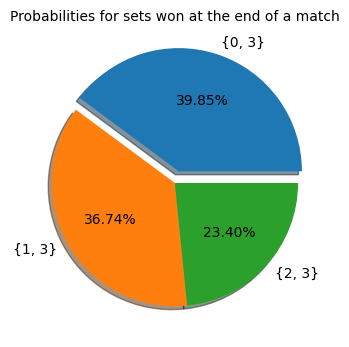

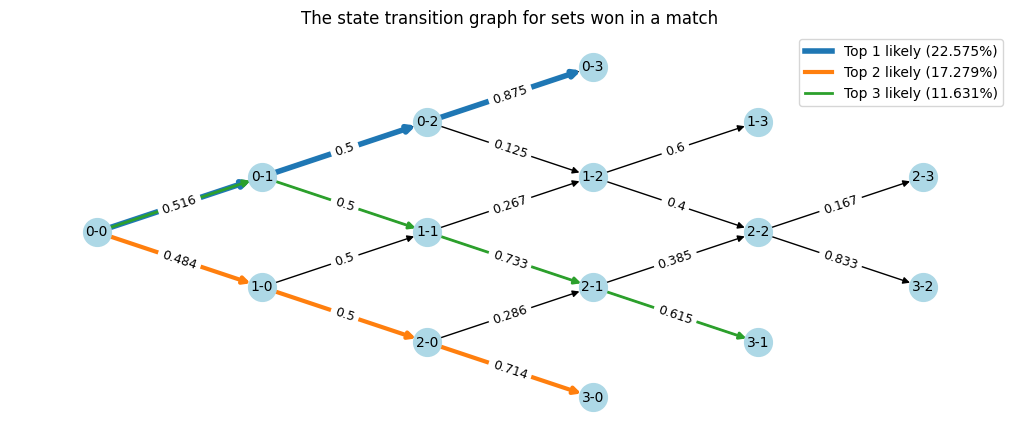

In [4]:
plot_markov(
    target="set",
    target_lo="game",
    target_hi="match",
    end_decision_func=lambda prev_state: prev_state[0] == 2 or prev_state[1] == 2,
    figsize=(10, 4),
    node_size=400,
    font_base=10,
)

The Markov chain of games won in a set.

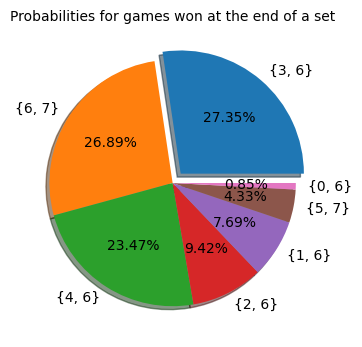

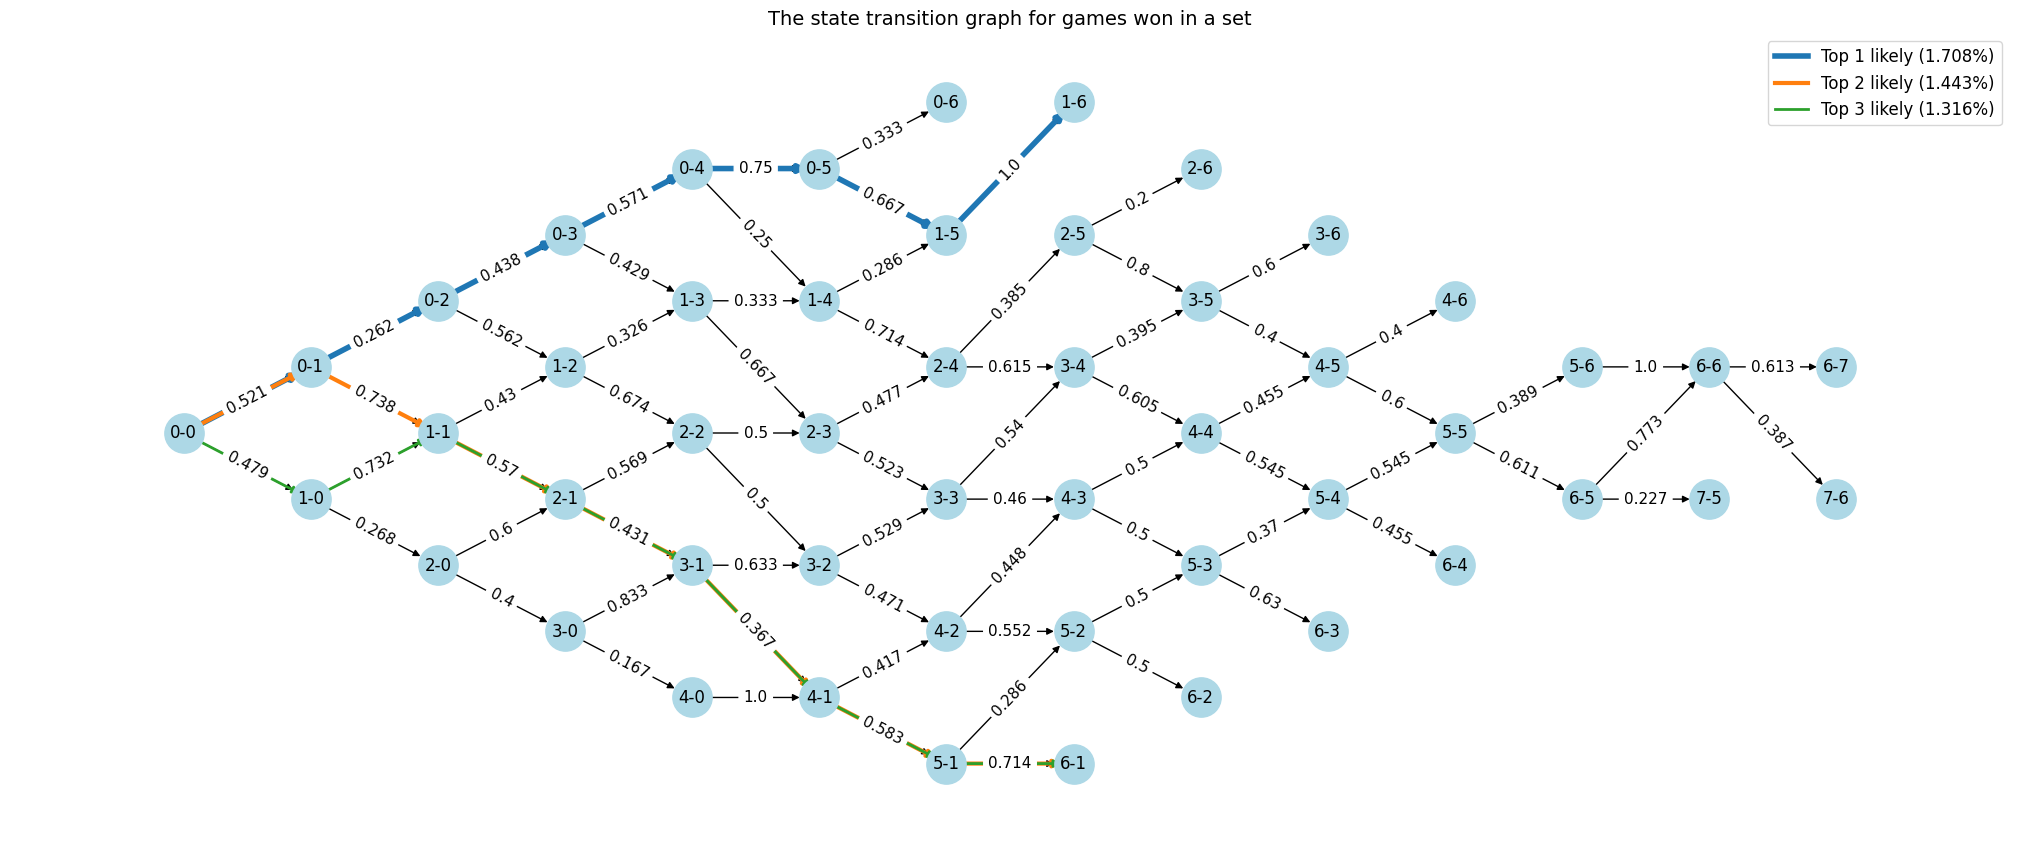

In [5]:
plot_markov(
    target="game",
    target_lo="point",
    target_hi="set",
    end_decision_func=lambda prev_state: prev_state[0] == 5
    or prev_state[1] == 5
    or prev_state == (6, 6),
    figsize=(20, 8),
    node_size=800,
    font_base=12,
)